In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cf
import netCDF4
import pandas as pd
import datetime
import pytz 
from tzwhere import tzwhere
import math
from suntime import Sun
import scipy as sci
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import cdo

In [73]:
import psutil

memory_info = psutil.virtual_memory()
print(f"Total Memory: {memory_info.total / (1024 ** 2):.2f} MB")
print(f"Available Memory: {memory_info.available / (1024 ** 2):.2f} MB")
print(f"Used Memory: {memory_info.used / (1024 ** 2):.2f} MB")
print(f"Memory Usage Percentage: {memory_info.percent:.2f}%")

Total Memory: 515782.86 MB
Available Memory: 282020.78 MB
Used Memory: 230368.87 MB
Memory Usage Percentage: 45.30%


In [83]:
def get_data_nights(len_data, NU_WU):  #len_data is the number of files i want to read in (e.g. 4 for 4h hourly data), NU_WU is a str and you can define if you want 'with urban' or 'no urban'
    ds_data = {}  
    for i in range(1, len_data + 1):
        filename = f'../det_data_nights_2022/fc_DOM01_0{i:03d}_{NU_WU}_urban_grid_nights.nc'
        try:
            ds_data[i] = xr.open_dataset(filename)
#            print(f'Successfully opened {filename}')
        except FileNotFoundError:
            print(f'File not found: {filename}')
        except Exception as e:
            print(f'An error occurred while opening {filename}: {e}')
    
    return ds_data

def get_data_nights_ens(len_data, NU_WU, mem):  #len_data is the number of files i want to read in (e.g. 4 for 4h hourly data), NU_WU is a str and you can define if you want 'with urban' or 'no urban'
    ds_data = {}  
    for i in range(1, len_data + 1):
        filename = f'../ensemble_members_nights/{mem}/fc_DOM01_0{i:03d}_{mem}_{NU_WU}_urban_grid_nights.nc'
        try:
            ds_data[i] = xr.open_dataset(filename)
#            print(f'Successfully opened {filename}')
        except FileNotFoundError:
            print(f'File not found: {filename}')
        except Exception as e:
            print(f'An error occurred while opening {filename}: {e}')
    
    return ds_data

def get_data_days(len_data, NU_WU):  #len_data is the number of files i want to read in (e.g. 4 for 4h hourly data), NU_WU is a str and you can define if you want 'with urban' or 'no urban'
    ds_data = {}  
    for i in range(1, len_data + 1):
        filename = f'../det_data_day_2022/fc_DOM01_0{i:03d}_{NU_WU}_urban_grid_days.nc'
        try:
            ds_data[i] = xr.open_dataset(filename)
#            print(f'Successfully opened {filename}')
        except FileNotFoundError:
            print(f'File not found: {filename}')
        except Exception as e:
            print(f'An error occurred while opening {filename}: {e}')
    
    return ds_data

def get_data_days_ens(len_data, NU_WU, mem):  #len_data is the number of files i want to read in (e.g. 4 for 4h hourly data), NU_WU is a str and you can define if you want 'with urban' or 'no urban'
    ds_data = {}  
    for i in range(1, len_data + 1):
        filename = f'../ensemble_members_days/{mem}/fc_DOM01_0{i:03d}_{mem}_{NU_WU}_urban_grid_days.nc'
        try:
            ds_data[i] = xr.open_dataset(filename)
#            print(f'Successfully opened {filename}')
        except FileNotFoundError:
            print(f'File not found: {filename}')
        except Exception as e:
            print(f'An error occurred while opening {filename}: {e}')
    
    return ds_data

def get_variable_1d_WU(len_data, data, variable, height_level, hour): #data is the output of 'get_data', variable is e.g. 'T' (as str), height_level (mostly 1 for urban), hour is time in this case 0 because one file only has one timestep
    ds_data = {}
    for i in range(1, len_data+1):
        ds_data[i] = data[i][f'{variable}'].isel(time = hour, height_3 = height_level)
    
    return ds_data

def get_variable_1d_NU(len_data, data, variable, height_level, hour): #data is the output of 'get_data', variable is e.g. 'T' (as str), height_level (mostly 1 for urban), hour is time in this case 0 because one file only has one timestep
    ds_data = {}
    for i in range(1, len_data+1):
        ds_data[i] = data[i][f'{variable}'].isel(time = hour, height = height_level)
    
    return ds_data

In [3]:
#read in the determinstic run files

data_WU_nights_det = get_data_nights(120, 'WU')
data_NU_nights_det = get_data_nights(120, 'NU')

In [110]:
data_WU_nights_det[120]

<xarray.Dataset>
Dimensions:      (cell: 185, nv: 3, height: 120, bnds: 2, time: 1,
                  height_2: 121, height_3: 1)
Coordinates:
  * time         (time) datetime64[ns] 2022-06-19T23:00:00
    clon         (cell) float64 ...
    clat         (cell) float64 ...
  * height       (height) float64 1.0 2.0 3.0 4.0 ... 117.0 118.0 119.0 120.0
  * height_2     (height_2) float64 1.0 2.0 3.0 4.0 ... 118.0 119.0 120.0 121.0
  * height_3     (height_3) float64 2.0
  * cell         (cell) int64 0 1 2 3 4 5 6 7 ... 237 238 239 240 241 245 246
Dimensions without coordinates: nv, bnds
Data variables:
    clon_bnds    (cell, nv) float64 ...
    clat_bnds    (cell, nv) float64 ...
    height_bnds  (height, bnds, cell) float64 ...
    U            (time, height, cell) float32 ...
    V            (time, height, cell) float32 ...
    TKE          (time, height_2, cell) float32 ...
    T_2M         (time, height_3, cell) float32 ...
    RELHUM       (time, height, cell) float32 ...
    QV           (time, height, cell) float32 ...
    QR           (time, height, cell) float32 ...
    daynight     (cell) object ...
Attributes:
    CDI:                  Climate Data Interface version 2.1.1 (https://mpime...
    Conventions:          CF-1.6
    number_of_grid_used:  26
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/ic...
    uuidOfHGrid:          a27b8de6-18c4-11e4-820a-b5b098c6a5c0
    uuidOfVGrid:          ec1be00c-e9fe-9627-26fd-24213ffd2ea0
    institution:          Deutscher Wetterdienst
    history:              Tue Feb 06 15:16:47 2024: cdo -setgrid,/p/scratch/d...
    CDO:                  Climate Data Operators version 2.1.1 (https://mpime...

In [5]:
data_WU_days_det = get_data_days(120, 'WU')
data_NU_days_det = get_data_days(120, 'NU')

In [6]:
#and the ensemeble files

#mem_ids = ['mem001', 'mem002', 'mem003', 'mem004', 'mem005', 'mem006', 'mem007', 'mem008', 'mem009', 'mem009', 'mem010',
#          'mem011', 'mem012', 'mem013', 'mem014', 'mem015', 'mem016', 'mem017', 'mem018', 'mem019', 'mem020', 'mem021', 
#          'mem022', 'mem023', 'mem024', 'mem025', 'mem026', 'mem027', 'mem028', 'mem029', 'mem030', 'mem031', 'mem032', 
#          'mem033', 'mem034', 'mem035', 'mem036', 'mem037', 'mem038', 'mem039', 'mem040']

mem_ids = ['mem001', 'mem002', 'mem003', 'mem004', 'mem005', 'mem006', 'mem007', 'mem008', 'mem009', 'mem009', 'mem010',
          'mem011', 'mem012', 'mem013', 'mem014', 'mem015', 'mem016', 'mem017', 'mem018', 'mem019', 'mem020']
data_WU_nights_mem = {}

for mem_id in mem_ids:
    data_WU_nights_mem[mem_id] = get_data_nights_ens(120, 'WU', mem_id)


In [41]:
data_WU_days_mem = {}

for mem_id in mem_ids:
    data_WU_days_mem[mem_id] = get_data_days_ens(120, 'WU', mem_id)

In [9]:
data_NU_nights_mem = {}

for mem_id in mem_ids:
    data_NU_nights_mem[mem_id] = get_data_nights_ens(120, 'NU', mem_id)


In [42]:
data_NU_days_mem = {}

for mem_id in mem_ids:
    data_NU_days_mem[mem_id] = get_data_days_ens(120, 'NU', mem_id)

In [63]:
T_2M_WU_nights_det = get_variable_1d_WU(120, data_WU_nights_det, 'T_2M', 0 , 0)
#T_2M_NU_nights_det = get_variable_1d(120, data_NU_nights_det, 'T_2M', 0 , 0)

In [68]:
T_2M_NU_nights_det = get_variable_1d_NU(120, data_NU_nights_det, 'T_2M', 0 , 0)

In [41]:
T_2M_WU_days_det = get_variable_1d_WU(118, data_WU_days_det, 'T_2M', 0 , 0)
T_2M_NU_days_det = get_variable_1d_NU(118, data_NU_days_det, 'T_2M', 0 , 0)

In [21]:
for i in range(1,118):
    path = f'../data_nights/temp/fc_DOM01_0{i:03d}_WU_urban_grid_nights_temp_det.nc'
    T_2M_WU_nights_det[i].to_netcdf(path=path)

In [22]:
for i in range(1,118):
    path = f'../data_nights/temp/fc_DOM01_0{i:03d}_NU_urban_grid_nights_temp_det.nc'
    T_2M_NU_nights_det[i].to_netcdf(path=path)

In [28]:
for i in range(1,118):
    path = f'../data_day/temp/fc_DOM01_0{i:03d}_WU_urban_grid_days_temp_det.nc'
    T_2M_WU_days_det[i].to_netcdf(path=path)

In [29]:
for i in range(1,118):
    path = f'../data_day/temp/fc_DOM01_0{i:03d}_NU_urban_grid_days_temp_det.nc'
    T_2M_NU_days_det[i].to_netcdf(path=path)

In [30]:
T_2M_WU_nights_mem = {}
T_2M_NU_nights_mem = {}

for mem_id in mem_ids:
    T_2M_WU_nights_mem[mem_id] = get_variable_1d(118, data_WU_nights_mem[mem_id], 'T_2M', 0 , 0)

for mem_id in mem_ids:
    T_2M_NU_nights_mem[mem_id] = get_variable_1d(118, data_NU_nights_mem[mem_id], 'T_2M', 0 , 0)

In [43]:
T_2M_WU_days_mem = {}
T_2M_NU_days_mem = {}

for mem_id in mem_ids:
    T_2M_WU_days_mem[mem_id] = get_variable_1d(118, data_WU_days_mem[mem_id], 'T_2M', 0 , 0)

for mem_id in mem_ids:
    T_2M_NU_days_mem[mem_id] = get_variable_1d(118, data_NU_days_mem[mem_id], 'T_2M', 0 , 0)

In [38]:
for mem_id in mem_ids:
    for i in range(1, 118):
        path = f'../ensemble_members_nights/{mem_id}/fc_DOM01_0{i:03d}_WU_urban_grid_nights_temp_{mem_id}.nc'
        T_2M_WU_nights_mem[mem_id][i].to_netcdf(path=path)

In [40]:
for mem_id in mem_ids:
    for i in range(1, 118):
        path = f'../ensemble_members_nights/{mem_id}/fc_DOM01_0{i:03d}_NU_urban_grid_nights_temp_{mem_id}.nc'
        T_2M_NU_nights_mem[mem_id][i].to_netcdf(path=path)

In [44]:
for mem_id in mem_ids:
    for i in range(1, 118):
        path = f'../ensemble_members_days/{mem_id}/fc_DOM01_0{i:03d}_WU_urban_grid_days_temp_{mem_id}.nc'
        T_2M_WU_days_mem[mem_id][i].to_netcdf(path=path)

In [45]:
for mem_id in mem_ids:
    for i in range(1, 118):
        path = f'../ensemble_members_days/{mem_id}/fc_DOM01_0{i:03d}_NU_urban_grid_days_temp_{mem_id}.nc'
        T_2M_NU_days_mem[mem_id][i].to_netcdf(path=path)

In [88]:
#sometimes there is an error, that the data has to laod (i don't know why) but then run this code

for i in range(1,118):
    T_2M_WU_nights_det[i]= T_2M_WU_nights_det[i].load().sortby('clon')
    
for i in range(1,118):
    T_2M_NU_nights_det[i]= T_2M_NU_nights_det[i].load().sortby('clon')

In [42]:
for i in range(1,118):
    T_2M_WU_days_det[i]= T_2M_WU_days_det[i].load().sortby('clon')
    
for i in range(1,118):
    T_2M_NU_days_det[i]= T_2M_NU_days_det[i].load().sortby('clon')

In [94]:
#cut out geographic regions, in this case southern europe

T_2M_WU_cEU_nights_det= {}
T_2M_NU_cEU_nights_det = {}

for i in range(1,118):
    T_2M_WU_cEU_nights_det[i] = T_2M_WU_nights_det[i].where(
    (T_2M_WU_nights_det[i]['clon'] >= 0.10472) &
    (T_2M_WU_nights_det[i]['clon'] <= 0.418879) &
    (T_2M_WU_nights_det[i]['clat'] >= 0.8030) &
    (T_2M_WU_nights_det[i]['clat'] <= 0.959931),
    drop=True
)
    
for i in range(1,118):
    T_2M_NU_cEU_nights_det[i] = T_2M_NU_nights_det[i].where(
    (T_2M_NU_nights_det[i]['clon'] >= 0.10472) &
    (T_2M_NU_nights_det[i]['clon'] <= 0.418879) &
    (T_2M_NU_nights_det[i]['clat'] >= 0.8030) &
    (T_2M_NU_nights_det[i]['clat'] <= 0.959931),
    drop=True
)

In [93]:
T_2M_WU_cEU_days_det= {}
T_2M_NU_cEU_days_det = {}

for i in range(1,118):
    T_2M_WU_cEU_days_det[i] = T_2M_WU_days_det[i].where(
    (T_2M_WU_days_det[i]['clon'] >= 0.10472) &
    (T_2M_WU_days_det[i]['clon'] <= 0.418879) &
    (T_2M_WU_days_det[i]['clat'] >= 0.8030) &
    (T_2M_WU_days_det[i]['clat'] <= 0.959931),
    drop=True
)
    
for i in range(1,118):
    T_2M_NU_cEU_days_det[i] = T_2M_NU_days_det[i].where(
    (T_2M_NU_days_det[i]['clon'] >= 0.10472) &
    (T_2M_NU_days_det[i]['clon'] <= 0.418879) &
    (T_2M_NU_days_det[i]['clat'] >= 0.8030) &
    (T_2M_NU_days_det[i]['clat'] <= 0.959931),
    drop=True
)

In [54]:
for mem_id in mem_ids:
    for i in range(1,118):
        T_2M_WU_nights_mem[mem_id][i]= T_2M_WU_nights_mem[mem_id][i].load().sortby('clon')
    

for mem_id in mem_ids:
    for i in range(1,118):
        T_2M_NU_nights_mem[mem_id][i]= T_2M_NU_nights_mem[mem_id][i].load().sortby('clon')

In [55]:
for mem_id in mem_ids:
    for i in range(1,118):
        T_2M_WU_days_mem[mem_id][i]= T_2M_WU_days_mem[mem_id][i].load().sortby('clon')
    

for mem_id in mem_ids:
    for i in range(1,118):
        T_2M_NU_days_mem[mem_id][i]= T_2M_NU_days_mem[mem_id][i].load().sortby('clon')

In [58]:
T_2M_WU_sEU_nights_mem = {}

for mem_id in mem_ids:
    T_2M_WU_sEU_nights_mem[mem_id] = {}
    for i in range(1, 118):
        T_2M_WU_sEU_nights_mem[mem_id][i] = T_2M_WU_nights_mem[mem_id][i].where(
            (T_2M_WU_nights_mem[mem_id][i]['clon'] >= -0.1827) &
            (T_2M_WU_nights_mem[mem_id][i]['clon'] <= 0.4475) &
            (T_2M_WU_nights_mem[mem_id][i]['clat'] >= 0.6629) &
            (T_2M_WU_nights_mem[mem_id][i]['clat'] <= 0.8030),
             drop=True
        )

T_2M_NU_sEU_nights_mem = {}

for mem_id in mem_ids:
    T_2M_NU_sEU_nights_mem[mem_id] = {}
    for i in range(1, 118):
        T_2M_NU_sEU_nights_mem[mem_id][i] = T_2M_NU_nights_mem[mem_id][i].where(
            (T_2M_NU_nights_mem[mem_id][i]['clon'] >= -0.1827) &
            (T_2M_NU_nights_mem[mem_id][i]['clon'] <= 0.4475) &
            (T_2M_NU_nights_mem[mem_id][i]['clat'] >= 0.6629) &
            (T_2M_NU_nights_mem[mem_id][i]['clat'] <= 0.8030),
            drop=True
        )

In [59]:
T_2M_WU_sEU_days_mem = {}

for mem_id in mem_ids:
    T_2M_WU_sEU_days_mem[mem_id] = {}
    for i in range(1, 118):
        T_2M_WU_sEU_days_mem[mem_id][i] = T_2M_WU_days_mem[mem_id][i].where(
            (T_2M_WU_days_mem[mem_id][i]['clon'] >= -0.1827) &
            (T_2M_WU_days_mem[mem_id][i]['clon'] <= 0.4475) &
            (T_2M_WU_days_mem[mem_id][i]['clat'] >= 0.6629) &
            (T_2M_WU_days_mem[mem_id][i]['clat'] <= 0.8030),
             drop=True
        )

T_2M_NU_sEU_days_mem = {}

for mem_id in mem_ids:
    T_2M_NU_sEU_days_mem[mem_id] = {}
    for i in range(1, 118):
        T_2M_NU_sEU_days_mem[mem_id][i] = T_2M_NU_days_mem[mem_id][i].where(
            (T_2M_NU_days_mem[mem_id][i]['clon'] >= -0.1827) &
            (T_2M_NU_days_mem[mem_id][i]['clon'] <= 0.4475) &
            (T_2M_NU_days_mem[mem_id][i]['clat'] >= 0.6629) &
            (T_2M_NU_days_mem[mem_id][i]['clat'] <= 0.8030),
            drop=True
        )

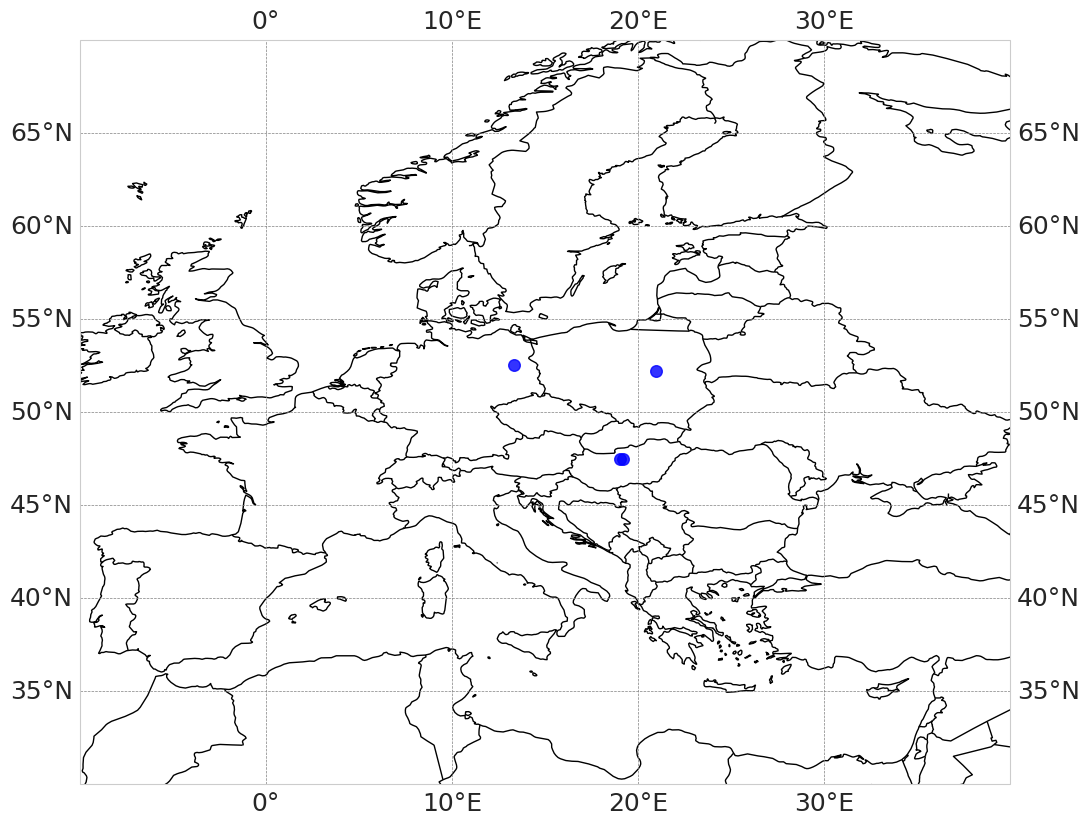

In [96]:
#visual quality check

cx_det = np.degrees(np.asarray(T_2M_WU_cEU_nights_det[1]["clon"]))
cy_det = np.degrees(np.asarray(T_2M_WU_cEU_nights_det[1]["clat"]))

#cx_mem = np.degrees(np.asarray(T_2M_WU_sEU_nights_mem['mem001'][1]["clon"]))
#cy_mem = np.degrees(np.asarray(T_2M_WU_sEU_nights_mem['mem001'][1]["clat"]))

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-10, 40, 30, 70], crs=ccrs.PlateCarree())
ax.scatter(cx_det, cy_det, s=70, c='blue', alpha=0.8, transform=ccrs.PlateCarree())
#ax.scatter(cx_mem, cy_mem, s=50, c='red', alpha=0.8, transform=ccrs.PlateCarree())
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.COASTLINE)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=0.5, color='gray')
#ax.plot([6, 24, 24, 6, 6], [46, 46, 55, 55, 46],
#         color='tomato', linewidth=3)

In [51]:
#get 2m temperature data

#T_2M_WU_sEU_nights_det = get_variable_1d(118, data_WU_sEU_nights_det, 'T_2M', 0 , 0)
#T_2M_NU_sEU_nights_det = get_variable_1d(118, data_NU_sEU_nights_det, 'T_2M', 0 , 0)

In [52]:
#T_2M_WU_sEU_days_det = get_variable_1d(118, data_WU_sEU_days_det, 'T_2M', 0 , 0)
#T_2M_NU_sEU_days_det = get_variable_1d(118, data_NU_sEU_days_det, 'T_2M', 0 , 0)

In [53]:
#T_2M_WU_sEU_nights_mem = {}
#T_2M_NU_sEU_nights_mem = {}

#for mem_id in mem_ids:
#    T_2M_WU_sEU_nights_mem[mem_id] = get_variable_1d(118, data_WU_sEU_nights_mem[mem_id], 'T_2M', 0 , 0)

#for mem_id in mem_ids:
#    T_2M_NU_sEU_nights_mem[mem_id] = get_variable_1d(118, data_NU_sEU_nights_mem[mem_id], 'T_2M', 0 , 0)

In [54]:
#T_2M_WU_sEU_days_mem = {}
#T_2M_NU_sEU_days_mem = {}

#for mem_id in mem_ids:
#    T_2M_WU_sEU_days_mem[mem_id] = get_variable_1d(118, data_WU_sEU_days_mem[mem_id], 'T_2M', 0 , 0)

#for mem_id in mem_ids:
#    T_2M_NU_sEU_days_mem[mem_id] = get_variable_1d(118, data_NU_sEU_days_mem[mem_id], 'T_2M', 0 , 0)

The data structure up to this point does not allow basic statistics (e.g., mean) over one city, just over all cities. So, the data is restructured in the following steps. xr.concat concatenates xarray objects along a new or existing dimension. With this, I have a 3D structure with the dimensions "city," "hour," and "temperature." Because the output of the concat was tuples in a list, it was needed to unzip the list to get arrays. This is required in order to plot them and do calculations.

In [99]:
T_2M_WU_cEU_nights_dim_hour_det = xr.concat(list(zip(*T_2M_WU_cEU_nights_det.items()))[1], dim = 'hour')
T_2M_NU_cEU_nights_dim_hour_det = xr.concat(list(zip(*T_2M_NU_cEU_nights_det.items()))[1], dim = 'hour')

In [98]:
T_2M_WU_cEU_days_dim_hour_det = xr.concat(list(zip(*T_2M_WU_cEU_days_det.items()))[1], dim = 'hour')
T_2M_NU_cEU_days_dim_hour_det = xr.concat(list(zip(*T_2M_NU_cEU_days_det.items()))[1], dim = 'hour')

In [64]:
T_2M_WU_sEU_nights_dim_hour_mem = {}
T_2M_NU_sEU_nights_dim_hour_mem = {}

for mem_id in mem_ids:
    T_2M_WU_sEU_nights_dim_hour_mem[mem_id] = xr.concat(list(zip(*T_2M_WU_sEU_nights_mem[mem_id].items()))[1], dim = 'hour')

for mem_id in mem_ids:
    T_2M_NU_sEU_nights_dim_hour_mem[mem_id] = xr.concat(list(zip(*T_2M_NU_sEU_nights_mem[mem_id].items()))[1], dim = 'hour')

In [65]:
T_2M_WU_sEU_days_dim_hour_mem = {}
T_2M_NU_sEU_days_dim_hour_mem = {}

for mem_id in mem_ids:
    T_2M_WU_sEU_days_dim_hour_mem[mem_id] = xr.concat(list(zip(*T_2M_WU_sEU_days_mem[mem_id].items()))[1], dim = 'hour')

for mem_id in mem_ids:
    T_2M_NU_sEU_days_dim_hour_mem[mem_id] = xr.concat(list(zip(*T_2M_NU_sEU_days_mem[mem_id].items()))[1], dim = 'hour')

In [100]:
sns.set_style("whitegrid")

In [67]:
#calculate the mean of the ensembles

all_values = []
mean_over_mem_WU_nights_cell = {}

for cell in range(4):  # Assuming there are 4 cells
    for i, mem_id in enumerate(mem_ids, start=1):
        values = T_2M_WU_sEU_nights_dim_hour_mem[mem_id].isel(cell=cell).values
        all_values.append(values)

    all_values_array = np.array(all_values)
    mean_over_mem_WU_nights_cell[cell] = np.mean(all_values_array, axis=0)
    all_values = [] 

In [68]:
all_values = []
mean_over_mem_NU_nights_cell = {}

for cell in range(4):  # Assuming there are 4 cells
    for i, mem_id in enumerate(mem_ids, start=1):
        values = T_2M_NU_sEU_nights_dim_hour_mem[mem_id].isel(cell=cell).values
        all_values.append(values)

    all_values_array = np.array(all_values)
    mean_over_mem_NU_nights_cell[cell] = np.mean(all_values_array, axis=0)
    all_values = [] 

In [69]:
all_values = []
mean_over_mem_WU_days_cell = {}

for cell in range(4):  # Assuming there are 4 cells
    for i, mem_id in enumerate(mem_ids, start=1):
        values = T_2M_WU_sEU_days_dim_hour_mem[mem_id].isel(cell=cell).values
        all_values.append(values)

    all_values_array = np.array(all_values)
    mean_over_mem_WU_days_cell[cell] = np.mean(all_values_array, axis=0)
    all_values = []  

In [70]:
all_values = []
mean_over_mem_NU_days_cell = {}

for cell in range(4):  # Assuming there are 4 cells
    for i, mem_id in enumerate(mem_ids, start=1):
        values = T_2M_NU_sEU_days_dim_hour_mem[mem_id].isel(cell=cell).values
        all_values.append(values)

    all_values_array = np.array(all_values)
    mean_over_mem_NU_days_cell[cell] = np.mean(all_values_array, axis=0)
    all_values = []  

Some variantions of plots: day and night, ensemble and determinstic

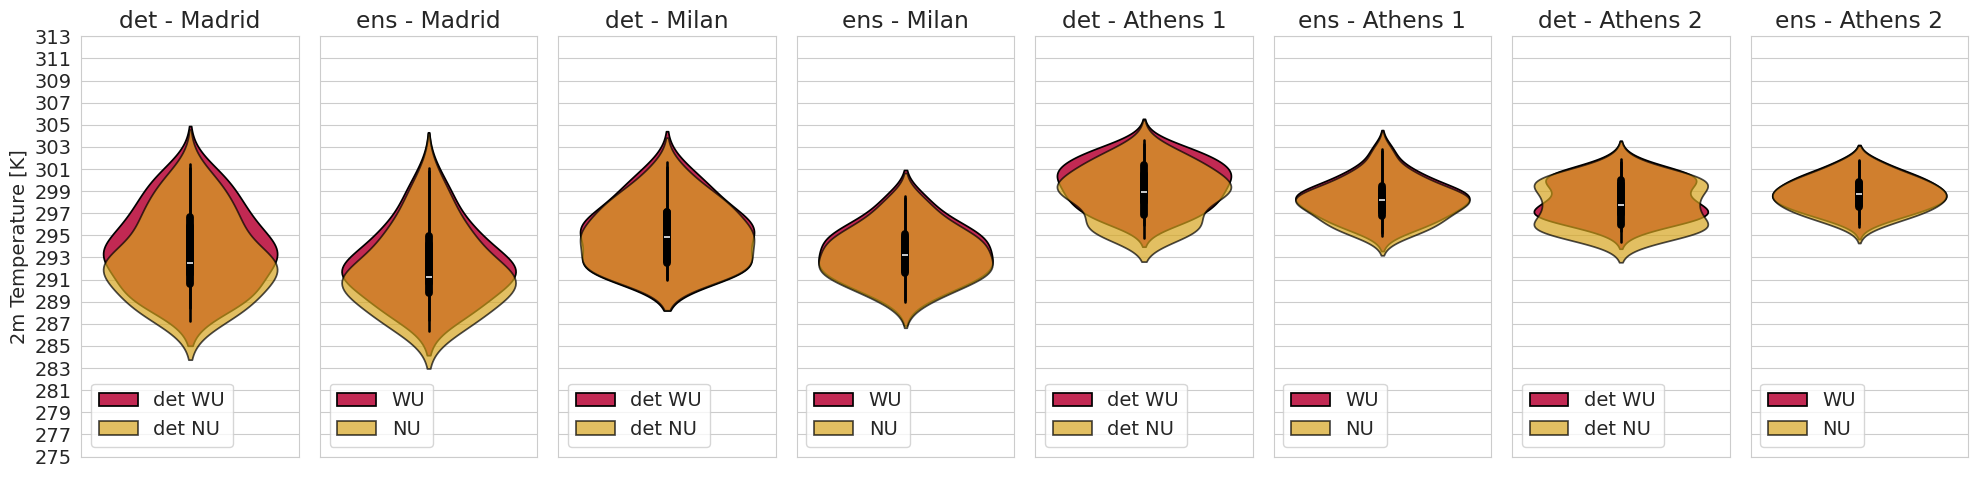

In [90]:
plt.rcParams.update({'font.size': 14})

num_cities = 4
city_names = ['Madrid', 'Milan', 'Athens 1', 'Athens 2']

y_min = 275
y_max = 312
step = 2
y_values = list(range(y_min, y_max + step, step))

fig, axes = plt.subplots(ncols=num_cities * 2, figsize=(20, 5))

# First for loop (odd-numbered subplots)
for i, city in enumerate(range(4)):
    values_det_WU = T_2M_WU_sEU_nights_dim_hour_det.isel(cell=city).values
    sns.violinplot(ax=axes[2*i], y=values_det_WU, label='det WU', color='#DB1048', fill=True, edgecolor='black')
    axes[2*i].set_title(f'det - {city_names[city]}')
    if i == 0:
        axes[2*i].set_ylabel('2m Temperature [K]')
    if i != 0:
        axes[2*i].axes.yaxis.set_ticklabels([])
    axes[2*i].set_ylim(y_min, y_max)
    axes[2*i].set_yticks(y_values)
    axes[2*i].legend(loc='lower left')

    values_det_NU = T_2M_NU_sEU_nights_dim_hour_det.isel(cell=city).values
    sns.violinplot(ax=axes[2*i], y=values_det_NU, alpha=0.7, label='det NU', color='#F4B301', fill=True, edgecolor='black')
    axes[2*i].set_title(f'det - {city_names[city]}')
    axes[2*i].set_ylim(y_min, y_max)
    axes[2*i].set_yticks(y_values)
    axes[2*i].legend(loc='lower left')

# Second for loop (even-numbered subplots)
for i, city in enumerate(range(4)):
    values_wu = mean_over_mem_WU_nights_cell[city]
    sns.violinplot(ax=axes[2*i + 1], y=values_wu, label='WU', color='#DB1048', fill=True, edgecolor='black')
    axes[2*i + 1].set_title(f'ens - {city_names[city]}')
    axes[2*i + 1].set_ylim(y_min, y_max)
    axes[2*i + 1].set_yticks(y_values)
    axes[2*i + 1].legend(loc='lower left')

    values_nu = mean_over_mem_NU_nights_cell[city]
    sns.violinplot(ax=axes[2*i + 1], y=values_nu, alpha=0.7, label='NU', color='#F4B301', fill=True, edgecolor='black')
    axes[2*i + 1].set_title(f'ens - {city_names[city]}')
    axes[2*i + 1].set_ylim(y_min, y_max)
    axes[2*i + 1].set_yticks(y_values)
    axes[2*i + 1].legend(loc='lower left')
    axes[2*i + 1].axes.yaxis.set_ticklabels([])

plt.tight_layout()
#plt.savefig('./plots/southern_europe_det_ens_nights.jpeg')
plt.show()



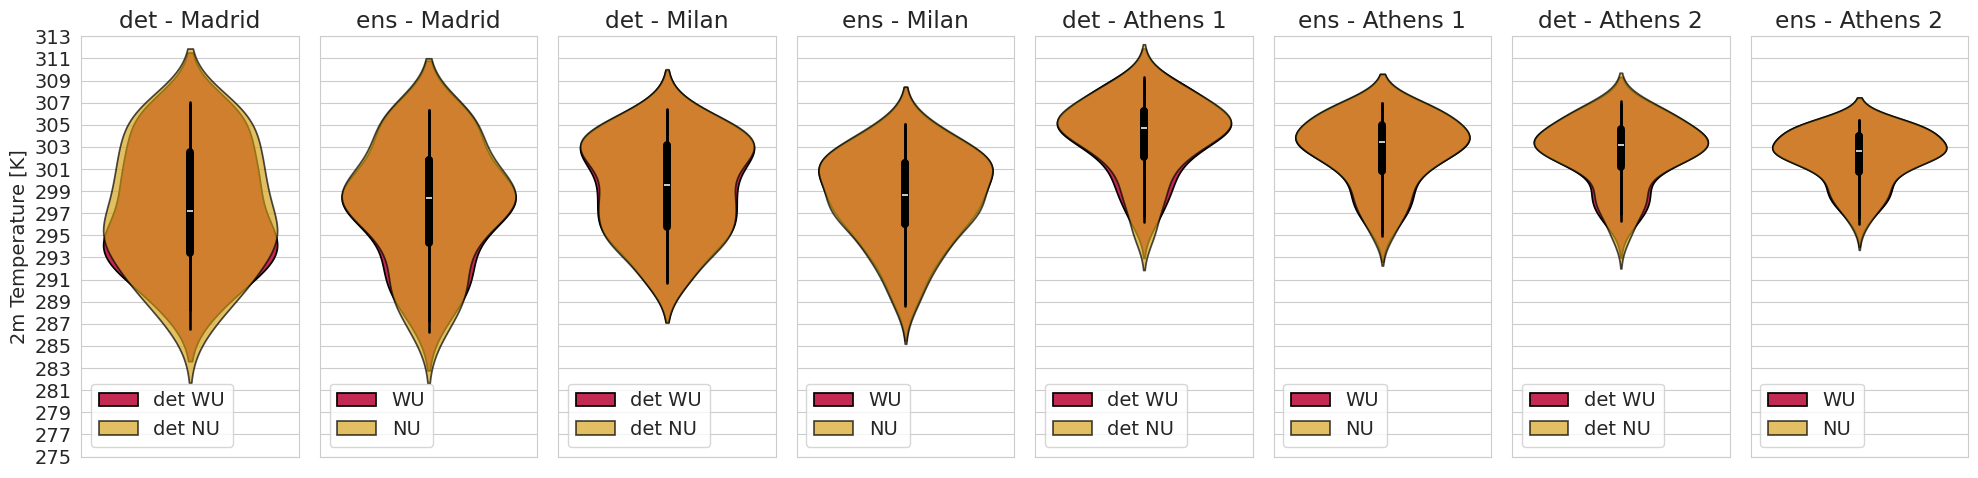

In [82]:
plt.rcParams.update({'font.size': 14})

num_cities = 4
city_names = ['Madrid', 'Milan', 'Athens 1', 'Athens 2']

y_min = 275
y_max = 312
step = 2
y_values = list(range(y_min, y_max + step, step))

fig, axes = plt.subplots(ncols=num_cities * 2, figsize=(20, 5))

# First for loop (odd-numbered subplots)
for i, city in enumerate(range(4)):
    values_det_WU = T_2M_WU_sEU_days_dim_hour_det.isel(cell=city).values
    sns.violinplot(ax=axes[2*i], y=values_det_WU, label='det WU', color='#DB1048', fill=True, edgecolor='black')
    axes[2*i].set_title(f'det - {city_names[city]}')
    if i == 0:
        axes[2*i].set_ylabel('2m Temperature [K]')
    if i != 0:
        axes[2*i].axes.yaxis.set_ticklabels([])
    axes[2*i].set_ylim(y_min, y_max)
    axes[2*i].set_yticks(y_values)
    axes[2*i].legend(loc='lower left')

    values_det_NU = T_2M_NU_sEU_days_dim_hour_det.isel(cell=city).values
    sns.violinplot(ax=axes[2*i], y=values_det_NU, alpha=0.7, label='det NU', color='#F4B301', fill=True, edgecolor='black')
    axes[2*i].set_title(f'det - {city_names[city]}')
    axes[2*i].set_ylim(y_min, y_max)
    axes[2*i].set_yticks(y_values)
    axes[2*i].legend(loc='lower left')

# Second for loop (even-numbered subplots)
for i, city in enumerate(range(4)):
    values_wu = mean_over_mem_WU_days_cell[city]
    sns.violinplot(ax=axes[2*i + 1], y=values_wu, label='WU', color='#DB1048', fill=True, edgecolor='black')
    axes[2*i + 1].set_title(f'ens - {city_names[city]}')
    axes[2*i + 1].set_ylim(y_min, y_max)
    axes[2*i + 1].set_yticks(y_values)
    axes[2*i + 1].legend(loc='lower left')

    values_nu = mean_over_mem_NU_days_cell[city]
    sns.violinplot(ax=axes[2*i + 1], y=values_nu, alpha=0.7, label='NU', color='#F4B301', fill=True, edgecolor='black')
    axes[2*i + 1].set_title(f'ens - {city_names[city]}')
    axes[2*i + 1].set_ylim(y_min, y_max)
    axes[2*i + 1].set_yticks(y_values)
    axes[2*i + 1].legend(loc='lower left')
    axes[2*i + 1].axes.yaxis.set_ticklabels([])

plt.tight_layout()
plt.savefig('./plots/southern_europe_det_ens_days.jpeg')
plt.show()

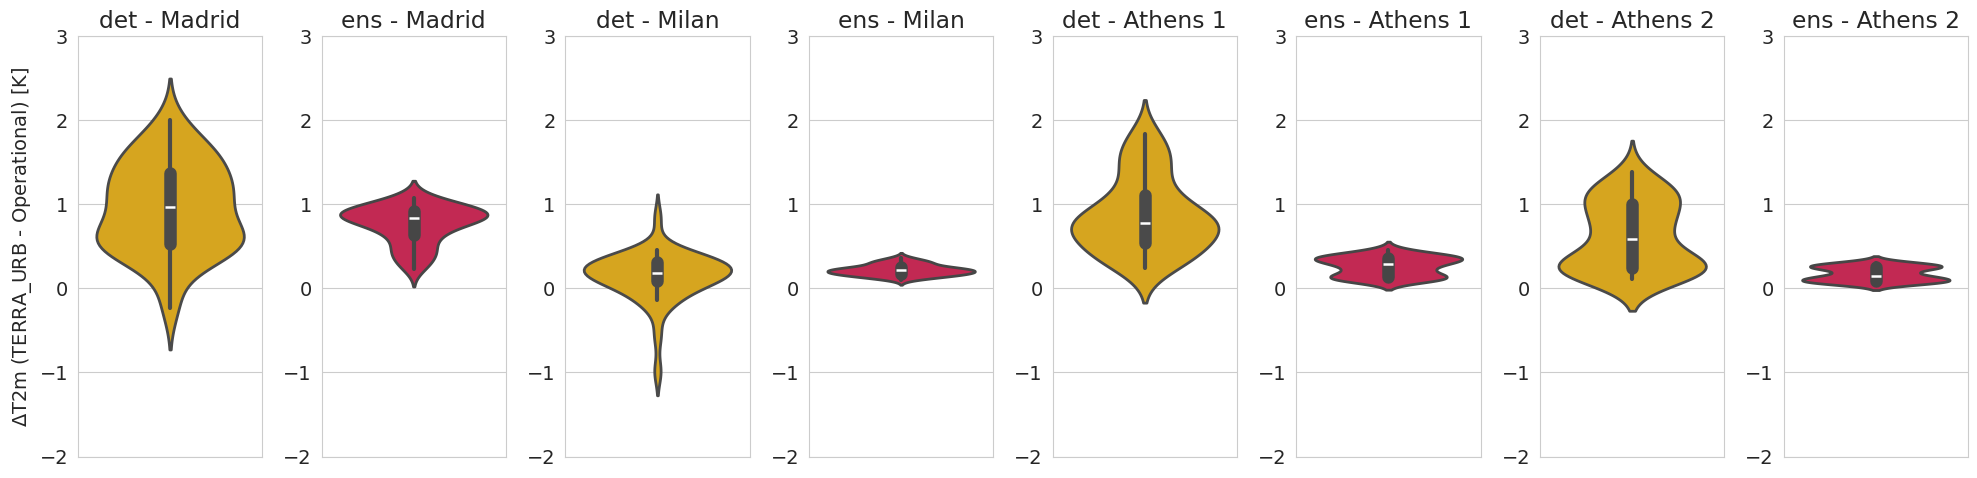

In [81]:
plt.rcParams.update({'font.size': 14})

num_members = 4
city_names = ['Madrid', 'Milan', 'Athens 1', 'Athens 2'] 

y_min = -2
y_max = 3
step = 1
y_values = list(range(y_min, y_max + step, step))

fig, axes = plt.subplots(ncols=num_members * 2, figsize=(20, 5))

# First for loop (odd-numbered subplots)
for i, city in enumerate(range(4)):
    values_det_WU = T_2M_WU_sEU_nights_dim_hour_det.isel(cell=city).values - T_2M_NU_sEU_nights_dim_hour_det.isel(cell=city).values
    sns.violinplot(ax=axes[2*i], y=values_det_WU, color='#F4B301', linewidth = 2)
    axes[2*i].set_title(f'det - {city_names[city]}')
    if i == 0:  
        axes[2*i].set_ylabel('$\Delta$T2m (TERRA_URB - Operational) [K]')
    axes[2*i].set_ylim(y_min, y_max)
    axes[2*i].set_yticks(y_values)

# Second for loop (even-numbered subplots)
for i, city in enumerate(range(4)):
    values_wu = mean_over_mem_WU_nights_cell[city] - mean_over_mem_NU_nights_cell[city]
    sns.violinplot(ax=axes[2*i + 1], y=values_wu, color='#DB1048', linewidth = 2)
    axes[2*i + 1].set_title(f'ens - {city_names[city]}')
    axes[2*i + 1].set_ylim(y_min, y_max)
    axes[2*i + 1].set_yticks(y_values)

plt.tight_layout()
plt.savefig('./plots/southern_europe_det_ens_diff_nights.jpeg')
plt.show()

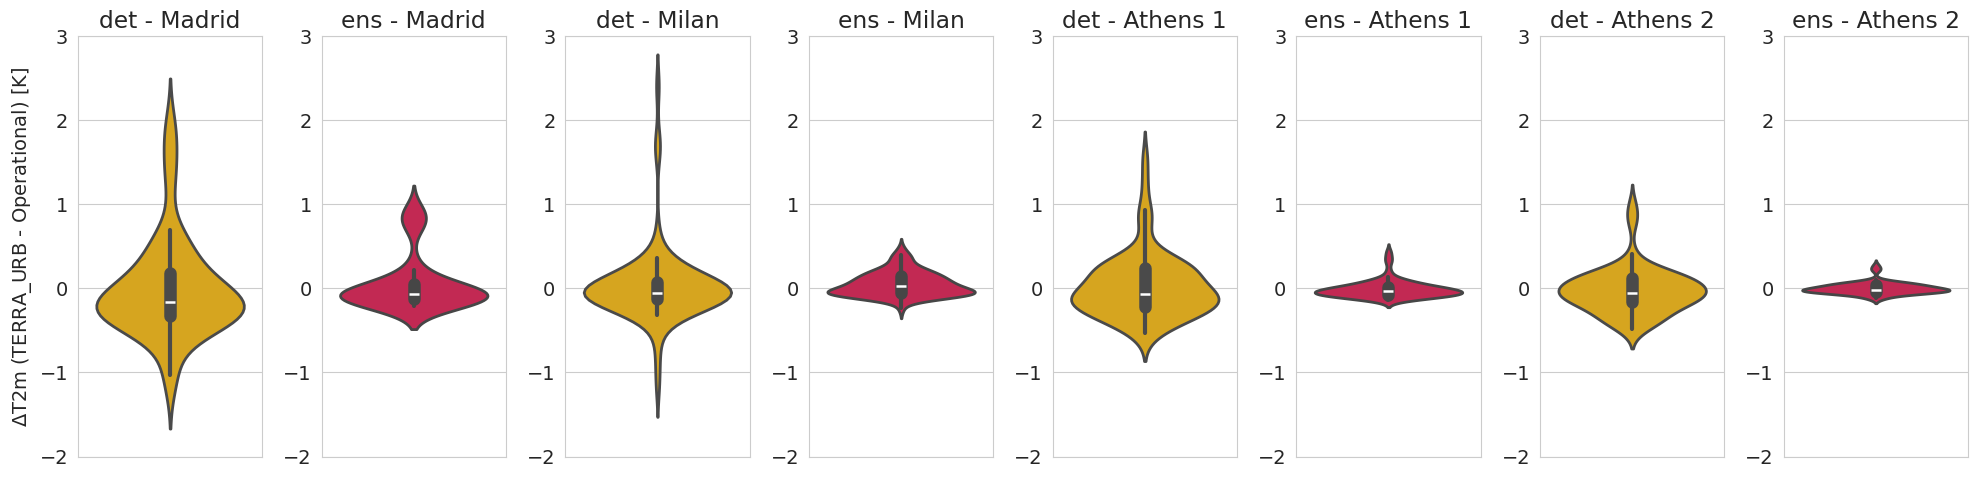

In [80]:
plt.rcParams.update({'font.size': 14})

num_members = 4
city_names = ['Madrid', 'Milan', 'Athens 1', 'Athens 2'] 

y_min = -2
y_max = 3
step = 1
y_values = list(range(y_min, y_max + step, step))

fig, axes = plt.subplots(ncols=num_members * 2, figsize=(20, 5))

# First for loop (odd-numbered subplots)
for i, city in enumerate(range(4)):
    values_det_WU = T_2M_WU_sEU_days_dim_hour_det.isel(cell=city).values - T_2M_NU_sEU_days_dim_hour_det.isel(cell=city).values
    sns.violinplot(ax=axes[2*i], y=values_det_WU, color='#F4B301', linewidth = 2)
    axes[2*i].set_title(f'det - {city_names[city]}')
    if i == 0:  
        axes[2*i].set_ylabel('$\Delta$T2m (TERRA_URB - Operational) [K]')
    axes[2*i].set_ylim(y_min, y_max)
    axes[2*i].set_yticks(y_values)

# Second for loop (even-numbered subplots)
for i, city in enumerate(range(4)):
    values_wu = mean_over_mem_WU_days_cell[city] - mean_over_mem_NU_days_cell[city]
    sns.violinplot(ax=axes[2*i + 1], y=values_wu, color='#DB1048', linewidth = 2)
    axes[2*i + 1].set_title(f'ens - {city_names[city]}')
    axes[2*i + 1].set_ylim(y_min, y_max)
    axes[2*i + 1].set_yticks(y_values)

plt.tight_layout()
plt.savefig('./plots/southern_europe_det_ens_diff_days.jpeg')
plt.show()

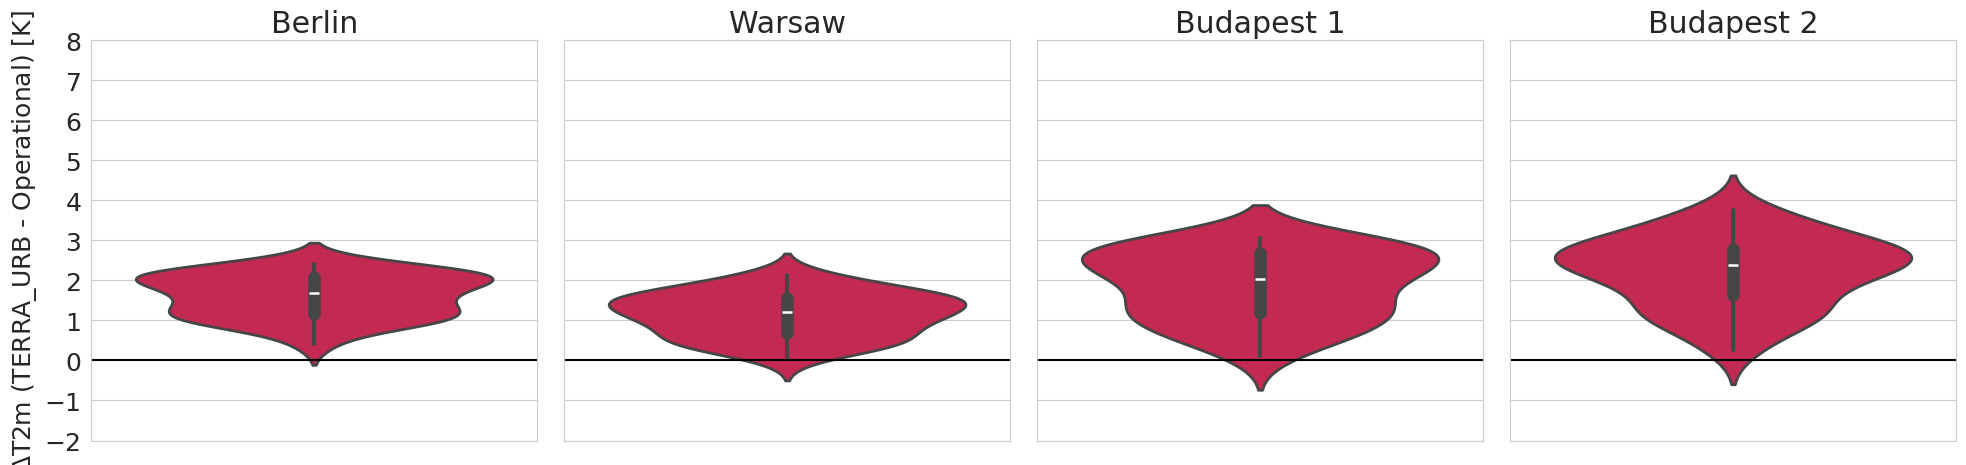

In [101]:
plt.rcParams.update({'font.size': 18})

num_cities = 4
city_names = ['Berlin', 'Warsaw', 'Budapest 1', 'Budapest 2']

y_min = -2
y_max = 8
step = 1
y_values = list(np.arange(y_min, y_max + step, step))

fig, axes = plt.subplots(ncols=num_cities, figsize=(20, 5))

# First for loop (odd-numbered subplots)
for i, city in enumerate(range(4)):
    values_det_WU = T_2M_WU_cEU_nights_dim_hour_det.isel(cell=city).values - T_2M_NU_cEU_nights_dim_hour_det.isel(cell=city).values
    sns.violinplot(ax=axes[i], y=values_det_WU, color='#DB1048', linewidth = 2)
    axes[i].set_title(f'{city_names[city]}')
    #axes[i].grid(True)
    if i == 0:  
        axes[i].set_ylabel('$\Delta$T2m (TERRA_URB - Operational) [K]' )
    if i != 0:
        axes[i].axes.yaxis.set_ticklabels([])
    axes[i].set_ylim(y_min, y_max)
    axes[i].set_yticks(y_values)
    #axes[i].legend(loc='lower left')
    axes[i].axhline(y=0, color='black', linestyle='-')



plt.tight_layout()
#plt.savefig('./plots/southern_europe_violinplots_det.jpeg')
plt.show()

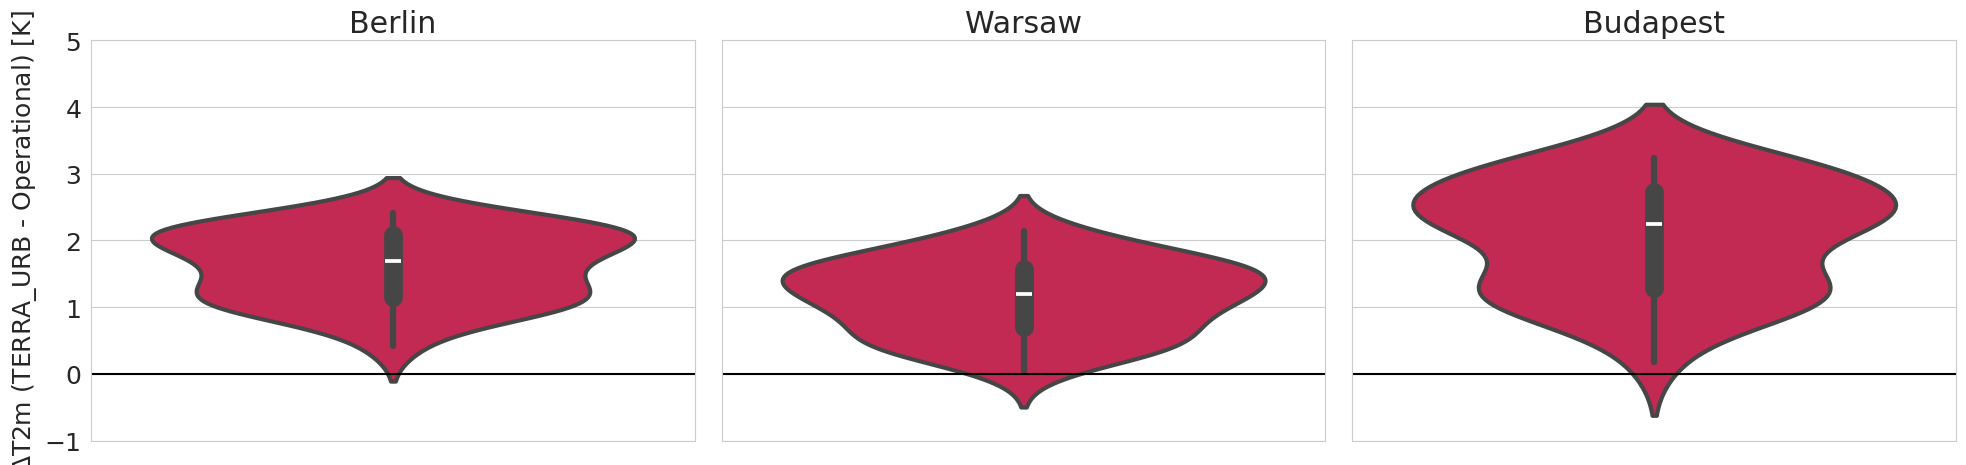

In [108]:
plt.rcParams.update({'font.size': 18})

num_cities = 3 
city_names = ['Berlin', 'Warsaw', 'Budapest']

y_min = -1
y_max = 5
step = 1
y_values = list(np.arange(y_min, y_max + step, step))

fig, axes = plt.subplots(ncols=num_cities, figsize=(20, 5))

# First for loop (odd-numbered subplots)
for i, city in enumerate(range(3)):  
    if city == 2:  #combining athens
        values_det_WU_athens = (
            T_2M_WU_cEU_nights_dim_hour_det.isel(cell=2).values
            - T_2M_NU_cEU_nights_dim_hour_det.isel(cell=2).values
            + T_2M_WU_cEU_nights_dim_hour_det.isel(cell=3).values
            - T_2M_NU_cEU_nights_dim_hour_det.isel(cell=3).values
        ) / 2
        sns.violinplot(ax=axes[i], y=values_det_WU_athens, color='#DB1048', linewidth=3)
        axes[i].set_title(f'{city_names[city]}')
#        axes[i].set_ylabel('$\Delta$T2m (TERRA_URB - Operational) [K]')
        axes[i].set_ylim(y_min, y_max)
        axes[i].set_yticks(y_values)
        axes[i].axhline(y=0, color='black', linestyle='-')
        axes[i].axes.yaxis.set_ticklabels([])
#        axes[i].grid(True)
    else:
        values_det_WU = T_2M_WU_cEU_nights_dim_hour_det.isel(cell=city).values - T_2M_NU_cEU_nights_dim_hour_det.isel(
            cell=city).values
        sns.violinplot(ax=axes[i], y=values_det_WU, color='#DB1048', linewidth=3)
        axes[i].set_title(f'{city_names[city]}')
        if i == 0:
            axes[i].set_ylabel('$\Delta$T2m (TERRA_URB - Operational) [K]')
        if i != 0:
            axes[i].axes.yaxis.set_ticklabels([])
        axes[i].set_ylim(y_min, y_max)
        axes[i].set_yticks(y_values)
        axes[i].axhline(y=0, color='black', linestyle='-')
 #       axes[i].grid(True)

plt.tight_layout()
plt.savefig('../plots/central_europe_violinplots_det_budapest_combined_22.jpeg')
plt.show()


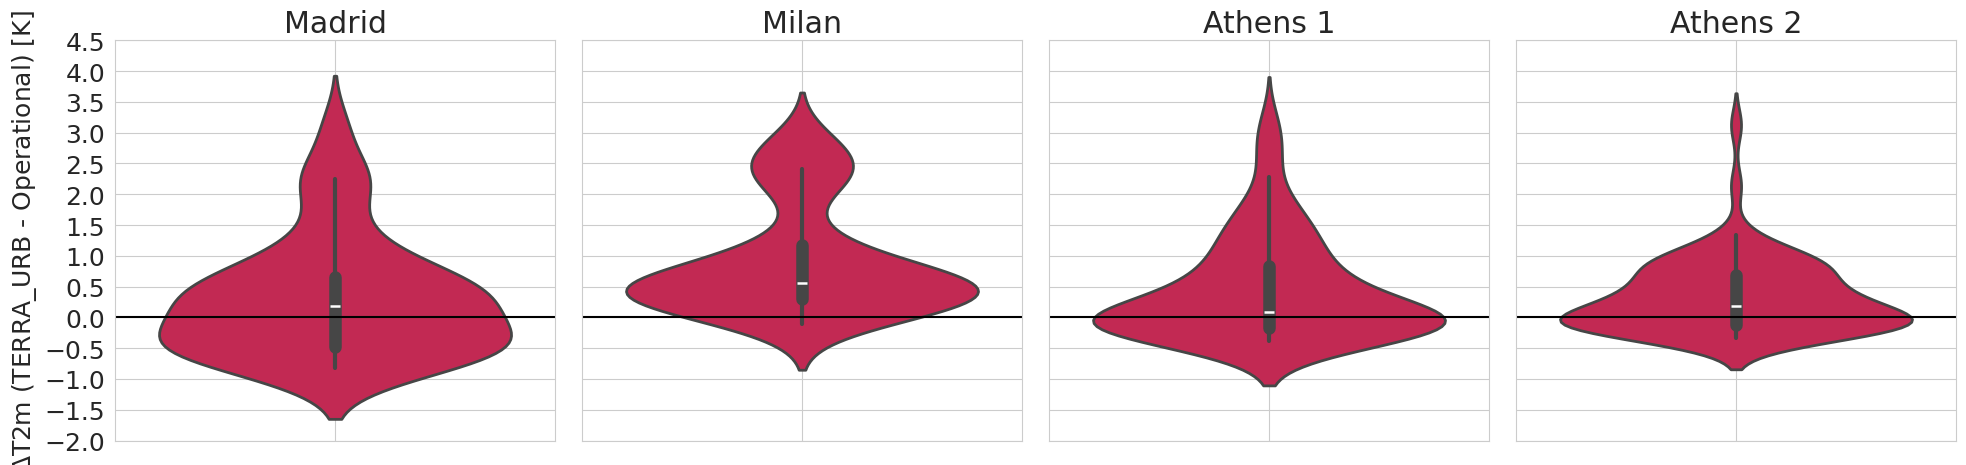

In [104]:
plt.rcParams.update({'font.size': 18})

num_cities = 4
city_names = ['Madrid', 'Milan', 'Athens 1', 'Athens 2'] 

y_min = -2
y_max = 4.5
step = .5
y_values = list(np.arange(y_min, y_max + step, step))

fig, axes = plt.subplots(ncols=num_cities, figsize=(20, 5))

# First for loop (odd-numbered subplots)
for i, city in enumerate(range(4)):
    values_det_WU = T_2M_WU_sEU_days_dim_hour_det.isel(cell=city).values - T_2M_NU_sEU_days_dim_hour_det.isel(cell=city).values
    sns.violinplot(ax=axes[i], y=values_det_WU, color='#DB1048', linewidth = 2)
    axes[i].set_title(f'{city_names[city]}')
    if i == 0:  
        axes[i].set_ylabel('$\Delta$T2m (TERRA_URB - Operational) [K]' )
    if i != 0:
        axes[i].axes.yaxis.set_ticklabels([])
    axes[i].set_ylim(y_min, y_max)
    axes[i].set_yticks(y_values)
    #axes[i].legend(loc='lower left')
    axes[i].axhline(y=0, color='black', linestyle='-')
    axes[i].grid(True)


plt.tight_layout()
#plt.savefig('./plots/southern_europe_violinplots_det_days.jpeg')
plt.show()

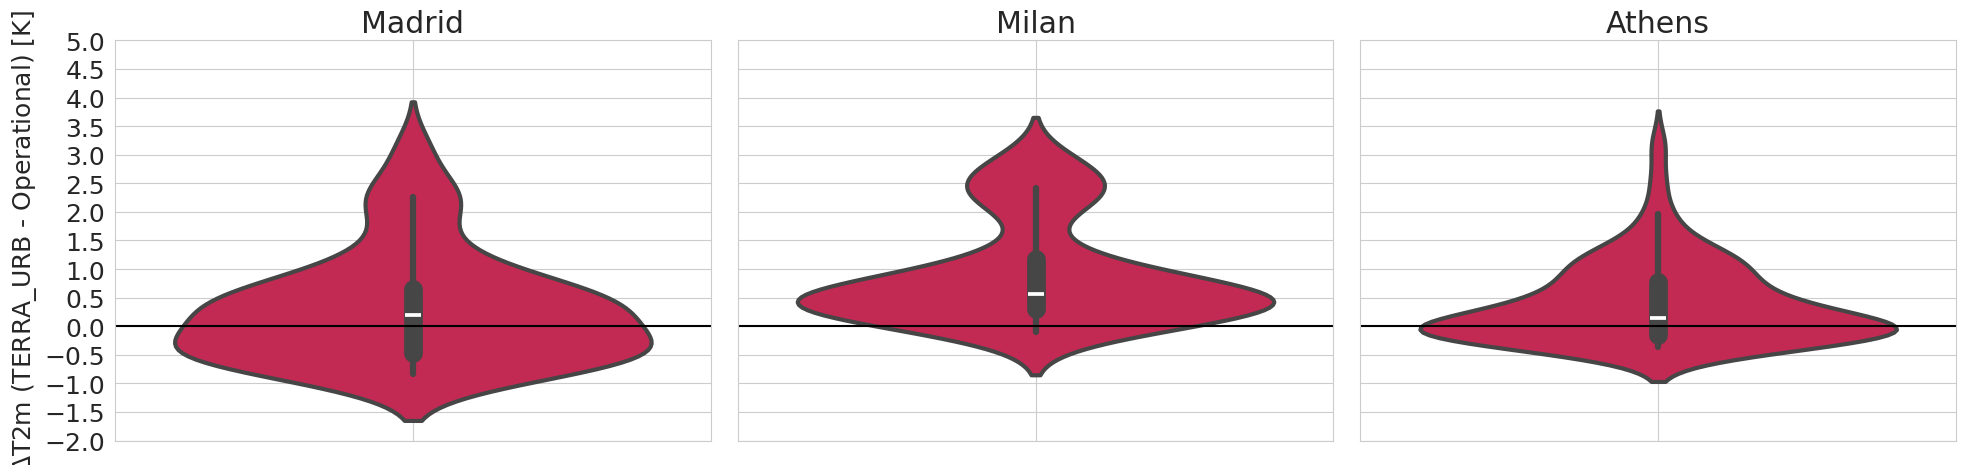

In [105]:
plt.rcParams.update({'font.size': 18})

num_cities = 3 
city_names = ['Madrid', 'Milan', 'Athens'] 

y_min = -2
y_max = 5
step = 0.5
y_values = list(np.arange(y_min, y_max + step, step))

fig, axes = plt.subplots(ncols=num_cities, figsize=(20, 5))

# First for loop (odd-numbered subplots)
for i, city in enumerate(range(3)):  
    if city == 2:  #combining athens
        values_det_WU_athens = (
            T_2M_WU_sEU_days_dim_hour_det.isel(cell=2).values
            - T_2M_NU_sEU_days_dim_hour_det.isel(cell=2).values
            + T_2M_WU_sEU_days_dim_hour_det.isel(cell=3).values
            - T_2M_NU_sEU_days_dim_hour_det.isel(cell=3).values
        ) / 2
        sns.violinplot(ax=axes[i], y=values_det_WU_athens, color='#DB1048', linewidth=3)
        axes[i].set_title(f'{city_names[city]}')
#        axes[i].set_ylabel('$\Delta$T2m (TERRA_URB - Operational) [K]')
        axes[i].set_ylim(y_min, y_max)
        axes[i].set_yticks(y_values)
        axes[i].axhline(y=0, color='black', linestyle='-')
        axes[i].axes.yaxis.set_ticklabels([])
        axes[i].grid(True)
    else:
        values_det_WU = T_2M_WU_sEU_days_dim_hour_det.isel(cell=city).values - T_2M_NU_sEU_days_dim_hour_det.isel(
            cell=city).values
        sns.violinplot(ax=axes[i], y=values_det_WU, color='#DB1048', linewidth=3)
        axes[i].set_title(f'{city_names[city]}')
        if i == 0:
            axes[i].set_ylabel('$\Delta$T2m (TERRA_URB - Operational) [K]')
        if i != 0:
            axes[i].axes.yaxis.set_ticklabels([])
        axes[i].set_ylim(y_min, y_max)
        axes[i].set_yticks(y_values)
        axes[i].axhline(y=0, color='black', linestyle='-')
        axes[i].grid(True)

plt.tight_layout()
#plt.savefig('../plots/southern_europe_violinplots_det_athens_combined_days.jpeg')
plt.show()
